In [1]:
import numpy as np

import albumentations as A
import cv2
from matplotlib import pyplot as plt
import os
import pandas as pd
import sys
import torch
import torchvision

from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms as T
from tqdm.notebook import tqdm
from typing import Callable, Iterable, List, Optional, Tuple, Union

In [2]:
sys.path.append('../src')

In [3]:
from omegaconf import ListConfig

from data.dataset import filter_by_source

In [4]:
DATA_DIR = Path('/media/dmitry/data/global-wheat-detection')

In [5]:
df = pd.read_csv(DATA_DIR/'train.csv')

In [6]:
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [7]:
df['source'].value_counts()

ethz_1       51489
arvalis_1    45716
rres_1       20236
arvalis_3    16665
usask_1       5807
arvalis_2     4179
inrae_1       3701
Name: source, dtype: int64

In [8]:
# image_id = str(df.loc[0, 'image_id'])
image_id = str(df.iloc[0, 0])
path = DATA_DIR/'train'/(image_id + '.jpg')
print(path)
# Image.open(path)

/media/dmitry/data/global-wheat-detection/train/b6ab77fd7.jpg


In [9]:
image = cv2.imread(str(path), cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [10]:
img_annots = df[df['image_id'] == image_id]
img_annots.head(3)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1


In [11]:
def draw_boxes(image: np.ndarray, bboxes: Iterable[np.ndarray]):
    for bb in bboxes:
        bb = bb[:4]
        assert len(bb) == 4
        if isinstance(bb, tuple):
            bb = tuple(map(int, bb))
        elif isinstance(bb, np.ndarray):
            bb = bb.astype(int)
        cv2.rectangle(image, tuple(bb[:2]), tuple(bb[2:]), (255, 0, 0), 1)

In [12]:
def make_dataset(image_dir: str, files: Iterable[str]) -> List[str]:
    image_dir = os.path.expanduser(image_dir)

    if not os.path.isdir(image_dir):
        raise RuntimeError("Unable to read folder {}".format(image_dir))

    images = [os.path.join(image_dir, f) for f in files]
    return images


def cv2_imread(path: Union[str, Path]) -> np.ndarray:
    image = cv2.imread(str(path), cv2.IMREAD_COLOR)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def read_bbox(bbox: str, bbox_format='pascal_voc') -> Tuple[int]:
    bb = map(float, bbox[1:-1].split(','))
    bb = list(map(int, bb))

    if len(bb) < 4:
        raise ValueError("Dumb bbox: {}".format(bbox))

    # 0 is a label
    if bbox_format == 'coco':
        bb = tuple(bb + [0])
    elif bbox_format == 'pascal_voc':
        x0, y0, w, h = bb
        bb = (x0, y0, x0 + w, y0 + h, 0)
    else:
        raise NotImplementedError(bbox_format)

    return bb


def bbox_str_to_numpy(bbox: str) -> np.ndarray:
    return np.array(read_bbox(bbox), dtype=np.uint16)

In [13]:
len(df.loc[df['image_id'] == 'b6ab77fd7', 'bbox'])

47

In [14]:
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [15]:
df['source'].value_counts()

ethz_1       51489
arvalis_1    45716
rres_1       20236
arvalis_3    16665
usask_1       5807
arvalis_2     4179
inrae_1       3701
Name: source, dtype: int64

In [16]:
class WheatDataset(Dataset):
    def __init__(self, image_dir, csv, gen_image_dirs=None, transforms=None, 
                 show_progress=True, source=None):
        # type: (str, str, Optional[List[str]], Optional[Transforms], Optional[bool], 
        #        Optional[DataSource]) -> None
        super(WheatDataset, self).__init__()
        self.transforms = transforms

        df = pd.read_csv(csv)
        ids = df['image_id'].unique()
        
        if show_progress:
            ids = tqdm(ids, desc="Parsing all bboxes...")

        id_to_ordinal = dict()
        bboxes = []
        for i, image_id in enumerate(ids):
            image_bb = df.loc[df['image_id'] == image_id, 'bbox']
            image_bb = np.stack(list(map(bbox_str_to_numpy, image_bb)))
            bboxes.append(image_bb)
            id_to_ordinal[image_id] = i
            
        assert len(bboxes) == len(id_to_ordinal)
        self.bboxes = bboxes
        self.id_to_ordinal = id_to_ordinal
        
        if source is not None:
            df = filter_by_source(df, source)
            ids = df['image_id'].unique()
            
        files = map(lambda x: x + '.jpg', ids)
        self.images = make_dataset(image_dir, files)
        self._num_orig_images = len(self.images)
        
        if gen_image_dirs is not None:
            for img_dir in gen_image_dirs:
                self.images += [os.path.join(img_dir, f) for f in os.listdir(img_dir)]

    def __getitem__(self, index):
        path = self.images[index]
        bboxes = self._find_bboxes(path)

        if not os.path.exists(path):
            print("Unable to read from {}".format(path))
            index = np.random.randint(len(self))
            # Bad luck :) Lets make another dice roll...
            return self[index]

        image = cv2_imread(path)

        if self.transforms is not None:
            out = self.transforms(image=image, bboxes=bboxes)
            image, bboxes = out['image'], out['bboxes']
            bboxes = np.stack(bboxes)
        else:
            image = torch.from_numpy(image)
            bboxes = torch.from_numpy(bboxes)

        # Remove class label and downcast from float64 to int16
        # to send less data to GPU. Some boxes have fractional part of .5,
        # but for high res images this shouldn't be an issue
        bboxes = bboxes[:, :4].astype(np.int16)
        return image, bboxes

    def _find_bboxes(self, path: str) -> int:
        file = os.path.split(path)[-1]
        image_id, ext = os.path.splitext(file)
        # Gets original image_id. Removes indexes from synthetic images if there are any
        image_id = image_id.split('_')[0]
        index = self.id_to_ordinal[image_id]
        return self.bboxes[index]

    def __len__(self):
        return len(self.images)

In [17]:
tfms = [
    A.Flip(),
    A.RandomRotate90(),
    A.Resize(512, 512, interpolation=cv2.INTER_AREA)
]

tfms = A.Compose(tfms, bbox_params=A.BboxParams('pascal_voc'))

In [18]:
%%time

image_dir = DATA_DIR/'train'
csv_path = DATA_DIR/'train.csv'

image_dirs = [
    image_dir,
    '/media/dmitry/data/kek/2020-07-16/18-43-45',
]

# ds = ExtendedWheatDataset(image_dirs, csv_path, transforms=tfms)

ds = WheatDataset(image_dir, csv_path, gen_image_dirs=image_dirs[1:], transforms=tfms, source=['usask_1'])


CPU times: user 24.5 s, sys: 127 ms, total: 24.6 s
Wall time: 22.3 s


In [19]:
len(ds)

704

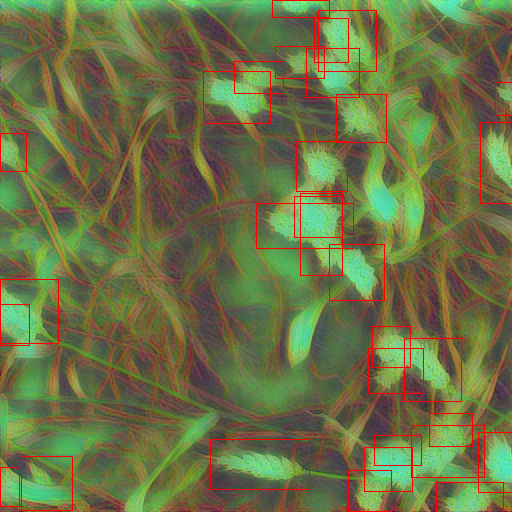

In [47]:
image, bboxes = ds[550]
draw_boxes(image, bboxes)
Image.fromarray(image)

In [21]:
def collate(batch):
    images, targets = tuple(zip(*batch))
    secret_sauce = torch.utils.data._utils.collate.default_collate
    images = secret_sauce(images)
    targets = list(map(secret_sauce, targets))
    return images, targets

In [22]:
dl = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True, collate_fn=collate)

In [23]:
images, targets = next(iter(dl))

images.shape, len(targets), targets[0].shape

(torch.Size([8, 512, 512, 3]), 8, torch.Size([21, 4]))